# Yolo

# Plate

In [1]:
from ultralytics import YOLO
from torchinfo import summary
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
model = YOLO('./weights/best(plate).pt')

In [3]:
summary(model)

Layer (type:depth-idx)                                       Param #
YOLO                                                         --
├─DetectionModel: 1-1                                        --
│    └─Sequential: 2-1                                       --
│    │    └─Conv: 3-1                                        (1,392)
│    │    └─Conv: 3-2                                        (41,664)
│    │    └─C2f: 3-3                                         (111,360)
│    │    └─Conv: 3-4                                        (166,272)
│    │    └─C2f: 3-5                                         (813,312)
│    │    └─Conv: 3-6                                        (664,320)
│    │    └─C2f: 3-7                                         (3,248,640)
│    │    └─Conv: 3-8                                        (1,991,808)
│    │    └─C2f: 3-9                                         (3,985,920)
│    │    └─SPPF: 3-10                                       (831,168)
│    │    └─Upsample: 3-11

In [4]:
image = cv2.imread('C:/Users/Alireza/Desktop/plate/2170593_FRONT.jpg')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

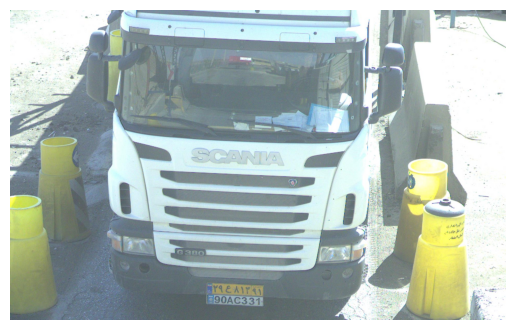

In [5]:
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

In [6]:
res = model(source=image, show=False, conf=0.6)


0: 416x640 2 plates, 79.0ms
Speed: 83.5ms preprocess, 79.0ms inference, 81.2ms postprocess per image at shape (1, 3, 416, 640)


In [12]:
res

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'plate'}
 obb: None
 orig_img: array([[[142, 154, 118],
         [140, 152, 116],
         [168, 179, 147],
         ...,
         [ 99, 102,  93],
         [ 95, 103,  93],
         [ 93, 102,  92]],
 
        [[141, 153, 117],
         [143, 155, 119],
         [172, 183, 151],
         ...,
         [ 99, 102,  93],
         [ 97, 102,  93],
         [ 95, 103,  93]],
 
        [[153, 165, 129],
         [158, 170, 134],
         [187, 198, 166],
         ...,
         [101, 102,  93],
         [ 99, 102,  93],
         [ 99, 102,  93]],
 
        ...,
 
        [[106,  94,  88],
         [107,  95,  89],
         [104,  93,  85],
         ...,
         [253, 255, 255],
         [253, 255, 255],
         [253, 255, 255]],
 
        [[104,  92,  86],
         [106,  94,  88],
         [105,  93,  87],
         ...,
         [255, 255,

In [7]:
bb = res[0].boxes

In [8]:
xy = bb.xyxy.cpu().numpy()

In [9]:
xy = np.array(bb.xyxy.cpu(), dtype=int)

In [10]:
cropped_image_0 = image[xy[0][1]:xy[0][3], xy[0][0]:xy[0][2]]
cropped_image_1 = image[xy[1][1]:xy[1][3], xy[1][0]:xy[1][2]]
gray_image_0 = cv2.cvtColor(cropped_image_0, cv2.COLOR_BGR2GRAY)
gray_image_1 = cv2.cvtColor(cropped_image_1, cv2.COLOR_BGR2GRAY)

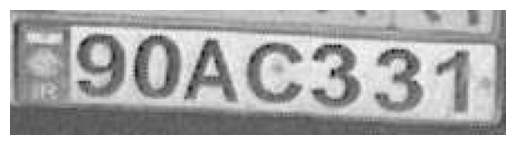

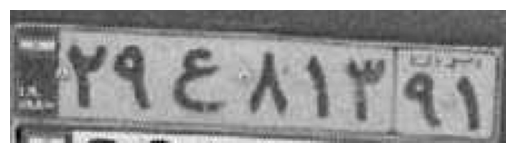

In [11]:
plt.imshow(gray_image_0, cmap='gray')
plt.axis('off')
plt.show()
plt.imshow(gray_image_1, cmap='gray')
plt.axis('off')
plt.show()

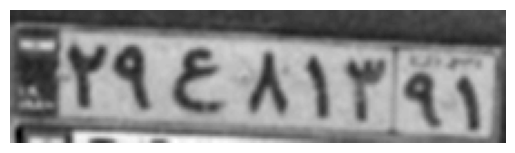

In [14]:
blurred = cv2.GaussianBlur(gray_image_1, (5, 5), 0)

plt.imshow(blurred, cmap='gray')
plt.axis('off')
plt.show()

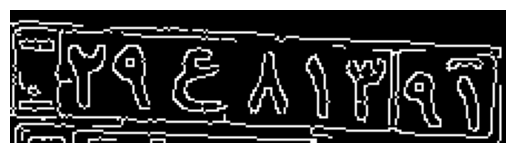

In [21]:
edges = cv2.Canny(blurred, 10, 70)

plt.imshow(edges, cmap='gray')
plt.axis('off')
plt.show()

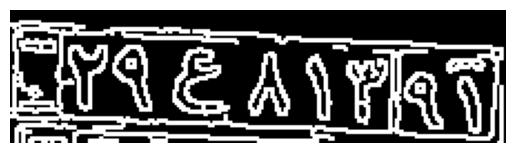

In [22]:
# Define a structuring element (kernel) for dilation
kernel_size = 2  # You can adjust this size
kernel = np.ones((kernel_size, kernel_size), np.uint8)  # Create a square kernel

# Apply dilation to thicken the edges
dilated_edges = cv2.dilate(edges, kernel, iterations=1)

plt.imshow(dilated_edges, cmap='gray')
plt.axis('off')
plt.show()

In [23]:
contours, _ = cv2.findContours(dilated_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

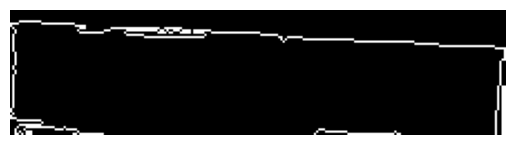

In [24]:
black_image = np.zeros_like(gray_image_0)
cv2.drawContours(black_image, contours, -1, (255, 255, 255), 1)  # White color for contours

plt.imshow(black_image, cmap='gray')
plt.axis('off')
plt.show()

In [25]:
largest_contour = sorted(contours, key=cv2.contourArea, reverse=True)[0]

In [26]:
epsilon = 0.05 * cv2.arcLength(largest_contour, True)  # Adjust epsilon for accuracy
approx = cv2.approxPolyDP(largest_contour, epsilon, True)

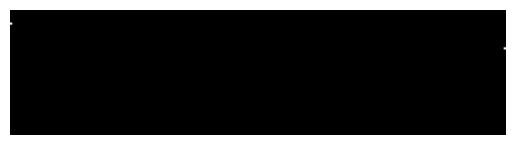

In [27]:
black_image = np.zeros_like(gray_image_0)
cv2.drawContours(black_image, approx, -1, (255, 255, 255), 1)  # White color for contours

plt.imshow(black_image, cmap='gray')
plt.axis('off')
plt.show()

In [30]:
image_height, image_width = gray_image_1.shape
top_left = np.array([0, 0])
top_right = np.array([image_width, 0])
bottom_left = np.array([0, image_height])
bottom_right = np.array([image_width, image_height])

# Calculate the L2 distances (Euclidean distance) for each corner
def l2_distance(p1, p2):
    return np.sqrt(np.sum((p1 - p2) ** 2))

# Find the closest point to each corner
nearest_top_left = approx[np.argmin([l2_distance(pt, top_left) for pt in approx])]
nearest_top_right = approx[np.argmin([l2_distance(pt, top_right) for pt in approx])]
nearest_bottom_left = approx[np.argmin([l2_distance(pt, bottom_left) for pt in approx])]
nearest_bottom_right = approx[np.argmin([l2_distance(pt, bottom_right) for pt in approx])]

# Display the results
corners = {
    "Top Left": nearest_top_left[0],
    "Top Right": nearest_top_right[0],
    "Bottom Right": nearest_bottom_right[0],
    "Bottom Left": nearest_bottom_left[0]
}

corners

{'Top Left': array([0, 6], dtype=int32),
 'Top Right': array([221,  17], dtype=int32),
 'Bottom Right': array([221,  59], dtype=int32),
 'Bottom Left': array([ 2, 59], dtype=int32)}

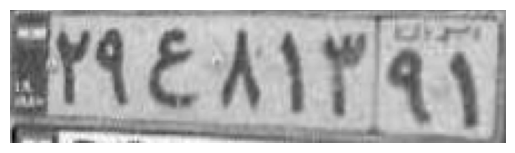

In [32]:
dst_points = np.array([[0, 0], [image_width, 0], [image_width, image_height], [0, image_height]], dtype=np.float32)
src_points  = np.array(list(corners.values()), dtype=np.float32)

M = cv2.getPerspectiveTransform(src_points, dst_points)
rectified_image = cv2.warpPerspective(gray_image_1, M, (image_width, image_height))

plt.imshow(rectified_image, cmap='gray')
plt.axis('off')
plt.show()

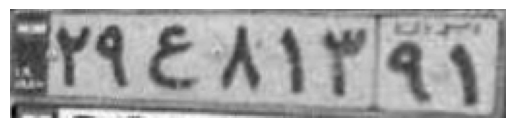

In [33]:
resizd_image = cv2.resize(rectified_image, (256,56), interpolation=cv2.INTER_LINEAR)

plt.imshow(resizd_image, cmap='gray')
plt.axis('off')
plt.show()

In [294]:
dst_points

array([[          0,           0],
       [        222,           0],
       [        222,          56],
       [          0,          56]], dtype=float32)

# Test

In [1]:
import services.ai_services.models as Models

yolo = Models.YOLOv8(Models.YoloType.Custom.Plate_best)

Loading YOLO model from weights/best(plate).pt ...

Layer (type:depth-idx)                                       Param #
YOLO                                                         --
├─DetectionModel: 1-1                                        --
│    └─Sequential: 2-1                                       --
│    │    └─Conv: 3-1                                        (1,392)
│    │    └─Conv: 3-2                                        (41,664)
│    │    └─C2f: 3-3                                         (111,360)
│    │    └─Conv: 3-4                                        (166,272)
│    │    └─C2f: 3-5                                         (813,312)
│    │    └─Conv: 3-6                                        (664,320)
│    │    └─C2f: 3-7                                         (3,248,640)
│    │    └─Conv: 3-8                                        (1,991,808)
│    │    └─C2f: 3-9                                         (3,985,920)
│    │    └─SPPF: 3-10                       

In [2]:
import services.image_handler.utils as IMUtils

In [ ]:
image = IMUtils.read_image('C:/Users/Alireza/Desktop/plate/2171038_FRONT.jpg')
image_rgb = IMUtils.convert_to_rgb(image)

IMUtils.show_image(image_rgb)

In [ ]:
image2 = IMUtils.read_image('C:/Users/Alireza/Desktop/plate/2170593_FRONT.jpg')
image_rgb2 = IMUtils.convert_to_rgb(image2)

IMUtils.show_image(image_rgb2)

In [5]:
import services.ai_services.inferences as yi

In [6]:
inference = yi.YOLOInference(yolo)

In [7]:
images = [image, image2]

Running full pipeline... 

conf=0.5, show=False, save=False
Running inference on Image

0: 416x640 2 plates, 31.3ms
1: 416x640 2 plates, 31.3ms
Speed: 16.5ms preprocess, 31.3ms inference, 39.7ms postprocess per image at shape (1, 3, 416, 640)
Yolo results are generated 

Found Bounding Boxes
Images are cropped 



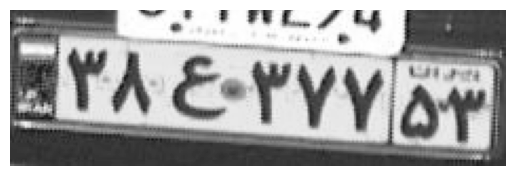

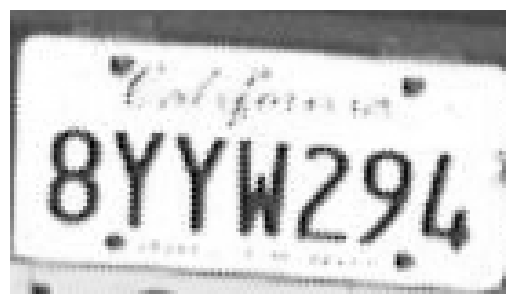

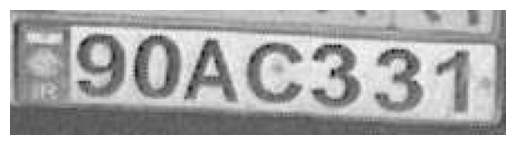

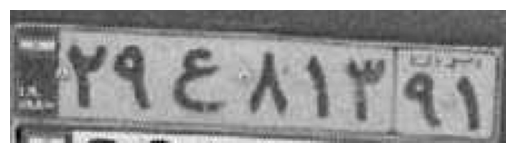

In [8]:
cropped_out = inference.run_full_pipeline(images)
for i in cropped_out:
    IMUtils.show_image(i, turn_grey=True, cmap='grey')